# LECTURE 14

## IMPORT MODULES

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as pp
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift

### LOAD DATA
To find the physical meaning of the different variables use the following link:

    https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

%# Download data file. To do only if haven't done already (I assume)

import requests

r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

In [2]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
# Fetching data

pos = data[3:6].astype(float)

T90 = data[6:8].astype(float)
fluence = data[9:11].astype(float)

# 1 - PLOT SOME DATA

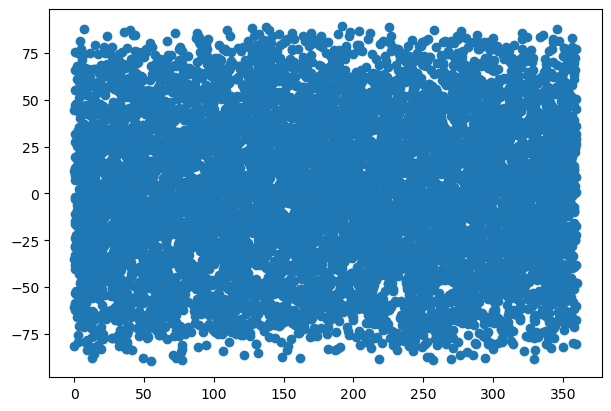

In [4]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

ax.scatter(pos[0], pos[1])

Text(0, 0.5, 'fluence')

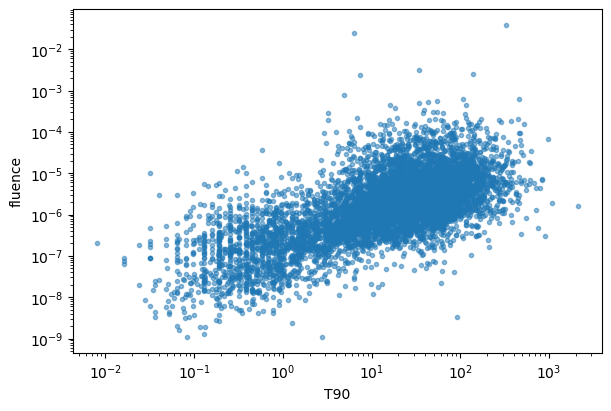

In [5]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

mask = (T90[0] != -999) & (fluence[0] != -999)

ax.plot(T90[0][mask], fluence[0][mask], '.', alpha=.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('T90')
ax.set_ylabel('fluence')

# 2 - CLUSTERING
The fluence vs T90 plot hint for the presence of two classes.

In [6]:
# Organize data for sklearn

mask = (T90[0] > 0) & (fluence[0] > 0)
X = np.column_stack([T90[0][mask], fluence[0][mask]])

x = np.log10(X)

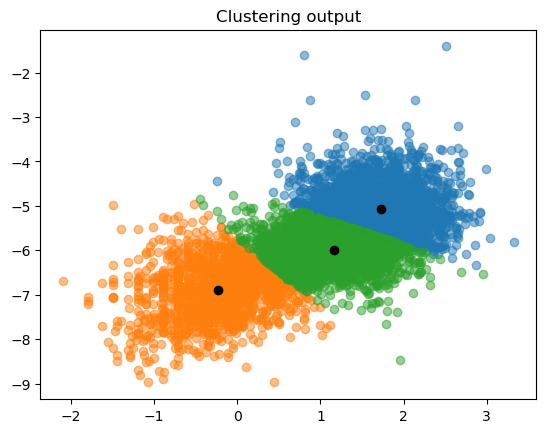

In [7]:
# KMEAN ALGORITHM

n_cl = 3 # try 2 clusters to start with

clf = KMeans(n_clusters=n_cl, n_init='auto')
clf.fit(x)
centers = clf.cluster_centers_ # location of the clusters
labels = clf.predict(x) # labels for each of the points

# Plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2', 'C3']
for ii in range(n_cl):
    plt.scatter(x[labels==ii, 0], x[labels==ii, 1], color=colors[ii], alpha=0.5)
plt.plot(centers[:, 0], centers[:, 1], 'o', color='k')

#plt.xscale('log')
#plt.yscale('log')

plt.title('Clustering output');

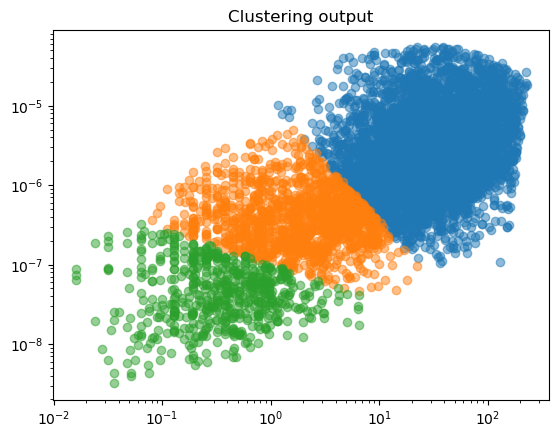

In [8]:
# MEAN-SHIFT ALGORITHM

n_cl = 3 # try 2 clusters to start with
bandwidth = 0.4

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(x)
centers = ms.cluster_centers_ # location of the clusters
labels = ms.predict(x) # labels for each of the points

# Plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii, 0], X[labels==ii, 1], alpha=0.5)#, color=colors[ii]

plt.xscale('log')
plt.yscale('log')

plt.title('Clustering output');